In [27]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [28]:
#hide
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

OSError: ignored

In [29]:
#hide
from fastbook import *
from fastai.vision.widgets import *

# clean


In [ ]:
key = os.environ.get('AZURE_SEARCH_KEY', 'XXX')

In [ ]:
search_images_bing

In [ ]:
results = search_images_bing(key, 'grizzly bear')
ims = results.attrgot('contentUrl')
len(ims)

In [ ]:
#hide
ims = ['http://3.bp.blogspot.com/-S1scRCkI3vY/UHzV2kucsPI/AAAAAAAAA-k/YQ5UzHEm9Ss/s1600/Grizzly%2BBear%2BWildlife.jpg']

In [ ]:
dest = 'images/grizzly.jpg'
download_url(ims[0], dest)

In [ ]:
im = Image.open(dest)
im.to_thumb(128,128)

In [30]:
material_types = 'chert', 'obsidian'
path = Path('/content/drive/MyDrive/Material_Types')

In [ ]:
if not path.exists():
    path.mkdir()
    for o in bear_types:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_bing(key, f'{o} bear')
        download_images(dest, urls=results.attrgot('contentUrl'))

In [35]:
fns = get_image_files(path)
fns

(#2000) [Path('/content/drive/MyDrive/Material_Types/Chert/Default-archeo_transparency_EXP00008-Chert-HH-2mm_20210504_141341(All particles)6168_425_02.bmp'),Path('/content/drive/MyDrive/Material_Types/Chert/Default-archeo_transparency_EXP00008-Chert-HH-2mm_20210504_141341(All particles)6168_425_01.bmp'),Path('/content/drive/MyDrive/Material_Types/Chert/Default-archeo_transparency_EXP00008-Chert-HH-2mm_20210504_141341(All particles)6168_425_04.bmp'),Path('/content/drive/MyDrive/Material_Types/Chert/Default-archeo_transparency_EXP00008-Chert-HH-2mm_20210504_141341(All particles)6199_429_04.bmp'),Path('/content/drive/MyDrive/Material_Types/Chert/Default-archeo_transparency_EXP00008-Chert-HH-2mm_20210504_141341(All particles)6168_425_05.bmp'),Path('/content/drive/MyDrive/Material_Types/Chert/Default-archeo_transparency_EXP00008-Chert-HH-2mm_20210504_141341(All particles)6168_425_03.bmp'),Path('/content/drive/MyDrive/Material_Types/Chert/Default-archeo_transparency_EXP00008-Chert-HH-2mm_202

In [ ]:
failed = verify_images(fns)
failed

In [ ]:
failed.map(Path.unlink);

## From Data to DataLoaders

In [36]:
materials = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

In [37]:
dls = materials.dataloaders(path)

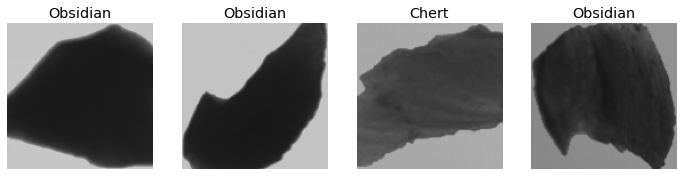

In [38]:
dls.valid.show_batch(max_n=4, nrows=1)

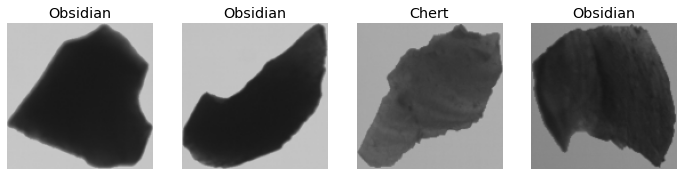

In [39]:
materials = materials.new(item_tfms=Resize(128, ResizeMethod.Squish))
dls = materials.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

In [ ]:
bears = bears.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros'))
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

In [ ]:
bears = bears.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True)

In [ ]:
bears = bears.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

## Training Your Model, and Using It to Clean Your Data

In [40]:
materials = materials.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = materials.dataloaders(path)

In [45]:
learn = cnn_learner(dls, resnet50, metrics=error_rate)
learn.fine_tune(12)

epoch,train_loss,valid_loss,error_rate,time
0,0.790194,0.680093,0.177500,00:18


epoch,train_loss,valid_loss,error_rate,time
0,0.385730,0.299794,0.080000,00:23
1,0.319648,0.204699,0.082500,00:23
2,0.270285,0.228381,0.067500,00:23
3,0.234878,0.223630,0.060000,00:24
4,0.212104,0.129442,0.042500,00:24
5,0.178727,0.123434,0.047500,00:24
6,0.134732,0.091620,0.040000,00:24
7,0.117152,0.109654,0.045000,00:24
8,0.093286,0.111046,0.035000,00:24
9,0.080619,0.074459,0.035000,00:24


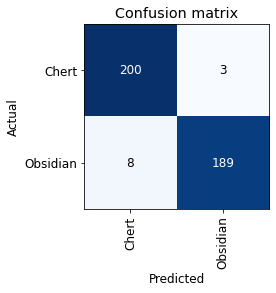

In [46]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [ ]:
interp.plot_top_losses(5, nrows=1)

In [ ]:
#hide_output
cleaner = ImageClassifierCleaner(learn)
cleaner

In [ ]:
#hide
# for idx in cleaner.delete(): cleaner.fns[idx].unlink()
# for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

## Turning Your Model into an Online Application

### Using the Model for Inference

In [ ]:
learn.export()

In [ ]:
path = Path()
path.ls(file_exts='.pkl')

In [ ]:
learn_inf = load_learner(path/'export.pkl')

In [ ]:
learn_inf.predict('images/grizzly.jpg')

In [ ]:
learn_inf.dls.vocab

### Creating a Notebook App

In [ ]:
#hide_output
btn_upload = widgets.FileUpload()
btn_upload

In [ ]:
#hide
# For the book, we can't actually click an upload button, so we fake it
btn_upload = SimpleNamespace(data = ['images/grizzly.jpg'])

In [ ]:
img = PILImage.create(btn_upload.data[-1])

In [ ]:
#hide_output
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128))
out_pl

In [ ]:
pred,pred_idx,probs = learn_inf.predict(img)

In [ ]:
#hide_output
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred

In [ ]:
#hide_output
btn_run = widgets.Button(description='Classify')
btn_run

In [ ]:
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)

In [ ]:
#hide
#Putting back btn_upload to a widget for next cell
btn_upload = widgets.FileUpload()

In [ ]:
#hide_output
VBox([widgets.Label('Select your bear!'), 
      btn_upload, btn_run, out_pl, lbl_pred])